In [1]:
from datetime import datetime, timezone
import matplotlib.pyplot as plt

from calc_sat_view import calc_sat_view
from draw_sat_view import draw_sat_view
from calc_sat_map import calc_sat_map
from draw_sat_map import draw_sat_map

In [2]:
def json_serial(obj):
    # 日付型の場合には、文字列に変換します
    if isinstance(obj, (datetime)):
        return obj.isoformat()
    # Timezoneも文字列にする
    if isinstance(obj, (timezone)):
        return obj.tzname(None)
    # 上記以外はサポート対象外.
    raise TypeError ("Type %s not serializable" % type(obj))

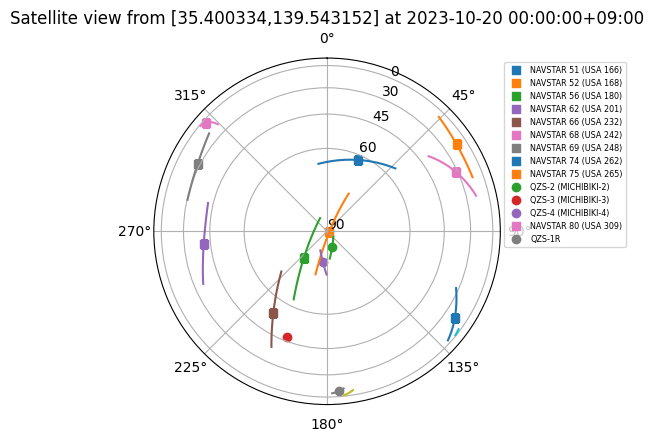

In [3]:
calc_results = calc_sat_view()#force_reload = True)
draw_sat_view(calc_results)
plt.savefig(f"satellite_view{calc_results['intermediate_params']['rounded_datetime'].strftime('%Y%m%d%H%M%S')}.png")
plt.savefig(f"satellite_view{calc_results['intermediate_params']['rounded_datetime'].strftime('%Y%m%d%H%M%S')}.svg")


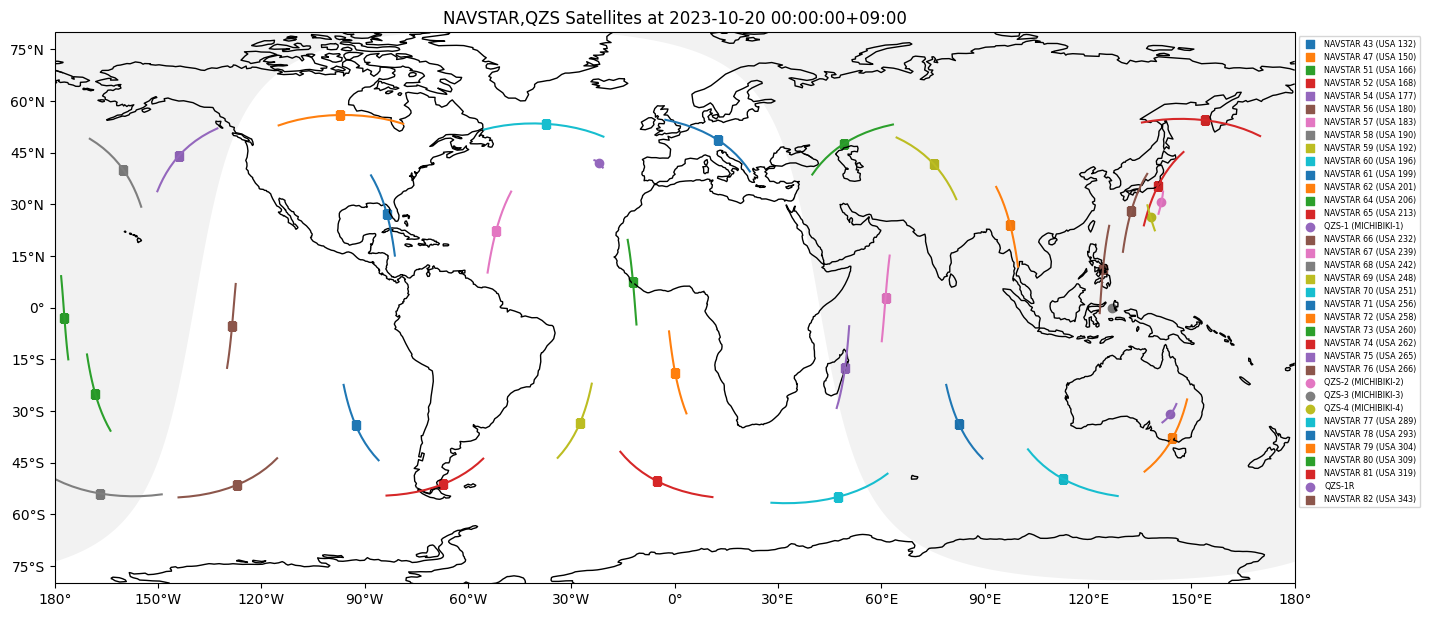

In [4]:
calc_results = calc_sat_map()#force_reload = True)
draw_sat_map(calc_results)
plt.savefig(f"satellite_map{calc_results['intermediate_params']['rounded_datetime'].strftime('%Y%m%d%H%M%S')}.png")
plt.savefig(f"satellite_map{calc_results['intermediate_params']['rounded_datetime'].strftime('%Y%m%d%H%M%S')}.svg")

